pytorch对变量的维度要求很高，例如(30, 28, 28)30张28x28的图像，需要将其拓展为(30, 1, 28, 28),对于图片来说还包含了'厚度'，因此需要
拓展1维，#The math of Linear: `y = xA^T + b`  因此在torch.nn.Linear中一行代表一个样例，而不是在课程中所学的一列代表一个样例。
因此在设计变量维度时，需要注意其数学形式

In [1]:
import torch
import torchvision
import torch.nn.functional as F   
import torch.utils.data as Data # 小批量学习
import matplotlib.pyplot as plt
import numpy as np
import os
import struct

In [2]:
'''加载数据'''
path = os.path.join(os.getcwd(), 'datasets')
def load_mnist(path, kind):
    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '%s-labels.idx1-ubyte'
                               % kind)
    images_path = os.path.join(path,
                               '%s-images.idx3-ubyte'
                               % kind)
    with open(labels_path, 'rb') as lbpath:
        magic, n = struct.unpack('>II',
                                 lbpath.read(8))
        labels = np.fromfile(lbpath,
                             dtype=np.uint8)
 
    with open(images_path, 'rb') as imgpath:
        magic, num, rows, cols = struct.unpack('>IIII',
                                               imgpath.read(16))
        images = np.fromfile(imgpath,
                             dtype=np.uint8).reshape(len(labels), 784)
 
    return images, labels
train_images, train_labels = load_mnist(path, 'train')
test_images, test_labels = load_mnist(path, 't10k')

<Figure size 432x288 with 0 Axes>

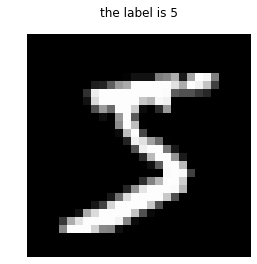

In [3]:
#hyper parameters
EPOCH = 1
LR = 0.001
BATCH_SIZE = 50

plt.figure()
plt.matshow(train_images[0].reshape(28, 28), cmap='gray')
plt.title('the label is %i'%train_labels[0],)
plt.axis('off')
plt.show()

'''小批量学习'''
train_images = train_images.reshape(60000, 28, 28) / 255 
train_images = torch.unsqueeze(torch.Tensor(train_images), dim=1)
train_labels = torch.Tensor(train_labels)
train_labels = train_labels.type(torch.long)
tensor_data = Data.TensorDataset(train_images, train_labels)
loader = Data.DataLoader(tensor_data, batch_size=BATCH_SIZE, shuffle=True, )

In [4]:
'''卷积网络搭建'''
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # ->(1, 28, 28)
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1, # 图片的'厚度'为1
                out_channels=16, # number of filters
                kernel_size=5,# 核大小
                stride=1,# 步长
                padding=2
            ),  #2d表示图片的维度是2维的
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )# ->(16, 14, 14)
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        ) # ->(32, 7, 7)
        self.out = torch.nn.Linear(32*7*7, 10)# 一个样例输出10个，一个样例一行
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x) # ->(batch, 37, 7, 7)
        x = x.view(x.size()[0], -1)
        output = self.out(x)
        return output

cnn = CNN()    
optimizer = torch.optim.Adam(cnn.parameters(), lr=LR)
loss_func = torch.nn.CrossEntropyLoss()
loss_arr = []
for step, (x_train_batch, y_train_batch) in enumerate(loader):
    output = cnn(x_train_batch)
    optimizer.zero_grad()
    loss = loss_func(output, y_train_batch)
    loss_arr.append(loss)
    loss.backward()
    optimizer.step()
torch.save(cnn.state_dict(), 'cnn-params.pkl')

NameError: name 'LR' is not defined

In [4]:
class CNN(torch.nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # ->(1, 28, 28)
        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(
                in_channels=1, # 图片的'厚度'为1
                out_channels=16, # number of filters
                kernel_size=5,# 核大小
                stride=1,# 步长
                padding=2
            ),  #2d表示图片的维度是2维的
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        )# ->(16, 14, 14)
        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(16, 32, 5, 1, 2),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=2)
        ) # ->(32, 7, 7)
        self.out = torch.nn.Linear(32*7*7, 10)# 一个样例输出10个，一个样例一行
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x) # ->(batch, 37, 7, 7)
        x = x.view(x.size()[0], -1)
        output = self.out(x)
        return output
cnn = CNN()
cnn.load_state_dict(torch.load('cnn-params.pkl'))
y_prediction = cnn(train_images[:20000])# 同时预测60000张会爆内存

In [5]:
soft = torch.nn.Softmax(dim=1)
y_prediction = soft(y_prediction)

In [6]:
y_pre_lable = y_prediction.max(dim=1)[1]
torch.sum(y_pre_lable==train_labels[:20000]).type(torch.float) / 20000 

tensor(0.9815)